# Machine Learning (Scikit-learn, XGBoost, LightGBM, CatBoost): Binary Classifier

In this document, the performance of 7 different Machine Learning (ML) algorithms are compared to solve the binary classification problem. The following algorithms are implemented:

Algorithm 1: LogisticRegression.

Algorithm 2: DecisionTreeClassifier.

Algorithm 3: RandomForestClassifier.

Algorithm 4: GradientBoostingClassifier.

Algorithm 5: XGBClassifier (XGBoost library).

Algorithm 6: LGBMClassifier (LightGBM library).

Algorithm 7: CatBoostClassifier (CatBoost library).

Finally, the best model is trained and saved to make predictions in production.

## Exploratory data analysis (EDA)

In [27]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import joblib
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Note that the following algorithms do not have attribute 'predict_proba' (they are used for regression), so classifiers are used instead.
```
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
```

In [28]:
# Read DataFrame
df = pd.read_csv('../data/raw/Electrical_Grid_Stability_us.csv', sep=';', header=0)

# Show DataFrame
df.head(3)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stability
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0


Column 'stability' will be renamed.

In [29]:
# Rename column 'stability' to 'Churn'
df = df.rename(columns={'stability': 'Churn'})

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  Churn   10000 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1015.8 KB


Format of all columns is correct.

## Data preprocessing

Data preprocessing consist of:
1. Filling null values and dropping duplicates.
2. Processing outliers and multicollinearity.
3. Converting categorical variables into binary ones.
4. Standardizing (scaling) the data.

### Fill null values and drop duplicates

In [30]:
# Verify the number of null values per column
df.isna().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
Churn    0
dtype: int64

In [31]:
# Delete duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

# Show duplicate rows
print(df.duplicated().sum())

0


### Process outliers and multicollinearity

A box plot is shown to verify if there exist outliers (no outliers).

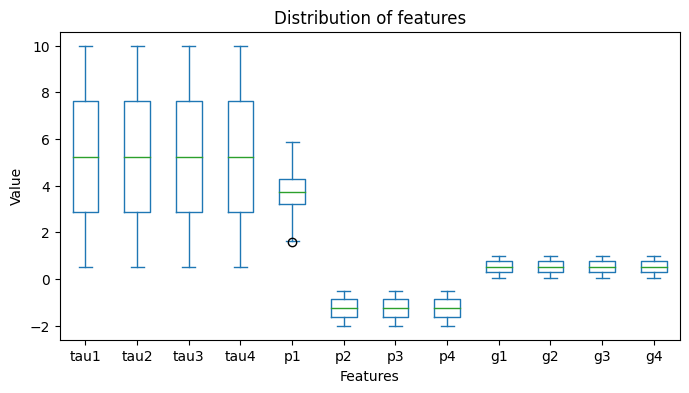

In [32]:
# Box plot
df.drop('Churn',axis=1).plot(kind='box', figsize=[8,4],
title='Distribution of features', xlabel='Features', ylabel='Value')
plt.xticks(rotation=0)
plt.show()

In order to see multicollinearity, a heatmap is shown.

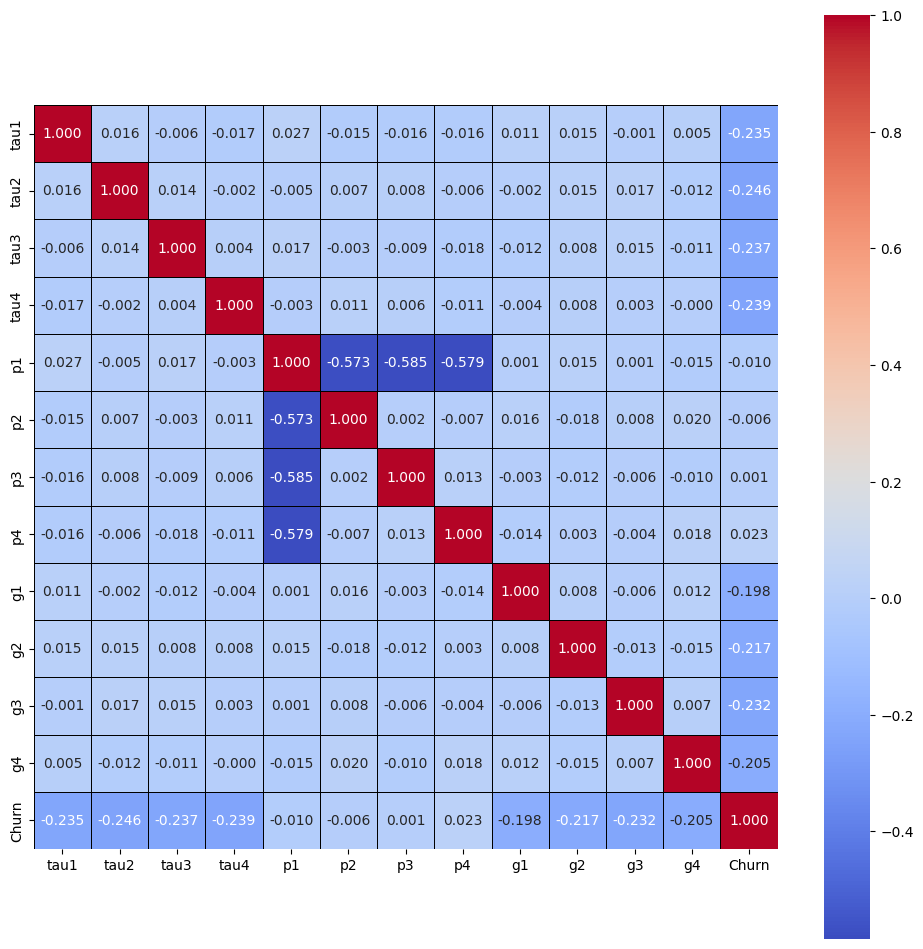

In [33]:
# Correlation matrix
cm = df.corr()

# Heatmap
plt.figure(figsize = (12,12))
sns.heatmap(cm, annot=True, square=True, cmap='coolwarm', fmt='.3f',
            annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.show()

It can be seen that columns 'p2' and 'p3' are partically not correlated to the objective variable 'Churn'. Besides, columns 'p2', 'p3' and 'p4' are correlated to 'p1'. It is not necessary to delete them, the algorithms can handle it.

### Convert categorical variables

DataFrame does not have categorical variables.

**Remark:** Processed data is saved.

In [34]:
# Save processed data
df.to_csv('../data/processed/Electrical_Grid_Stability_processed.csv', index=False)

# DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  Churn   10000 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 1015.8 KB


### Data standarization

In [35]:
# Obtain characteristic matrix (x) and objective variable (y)
x = df.drop('Churn', axis=1)
y = df['Churn']

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

# Train the StandardScaler by using 'x_train'
scaler = StandardScaler()
scaler.fit(x_train)

# Standardize x_test and x_test
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

# Save scaler
joblib.dump(scaler, '../models/bc_scaler.pkl')

['../models/bc_scaler.pkl']

The data for training and validation are ready.

**Remark:** By verifying data balance, it can be seen that data is not balanced, but this unbalance is handled with the hyperparameter class_weight='balanced' (if applicable).

In [36]:
# Ratio between binary classes
df['Churn'].value_counts()

Churn
0    6380
1    3620
Name: count, dtype: int64

## Models creation (with Scikit-Learn)

Four different models will be created.

**Remak:** 'GradientBoostingClassifier' does not have the hyperparameter class_weight='balanced', upsample and downsample techniques should be applied, but in this application, 'GradientBoostingClassifier' is not affected.

In [37]:
# Define the binary classifier models
models = [LogisticRegression(random_state=0, class_weight='balanced'),
    DecisionTreeClassifier(random_state=0, class_weight='balanced'),
    RandomForestClassifier(n_estimators=100, random_state=0,
                           class_weight='balanced'),
    GradientBoostingClassifier(n_estimators=100, random_state=0)
]

def make_prediction(m, x_train, y_train, x_test, y_test):
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)
    y_proba = m.predict_proba(x_test)[:, 1]
    print('\tAccuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))
    print('\tPrecision: {:.2%}'.format(precision_score(y_test, y_pred)))
    print('\tRecall: {:.2%}'.format(recall_score(y_test, y_pred)))
    print('\tF1: {:.2%}'.format(f1_score(y_test, y_pred)))
    print('\tROC_AUC: {:.2%}'.format(roc_auc_score(y_test, y_proba)))

In [38]:
# Iterate through the models and make predictions
for i in models:
    print("---------------------------------------------------")
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

---------------------------------------------------
LogisticRegression(class_weight='balanced', random_state=0)
	Accuracy: 79.50%
	Precision: 68.85%
	Recall: 79.64%
	F1: 73.85%
	ROC_AUC: 88.97%
---------------------------------------------------
DecisionTreeClassifier(class_weight='balanced', random_state=0)
	Accuracy: 83.90%
	Precision: 80.00%
	Recall: 74.28%
	F1: 77.03%
	ROC_AUC: 81.84%
---------------------------------------------------
RandomForestClassifier(class_weight='balanced', random_state=0)
	Accuracy: 91.95%
	Precision: 92.37%
	Recall: 84.87%
	F1: 88.46%
	ROC_AUC: 98.03%
---------------------------------------------------
GradientBoostingClassifier(random_state=0)
	Accuracy: 92.65%
	Precision: 94.07%
	Recall: 85.14%
	F1: 89.39%
	ROC_AUC: 97.93%


**Conclusion:** 'Gradient Boosting Classifier' obtained better results. RandomForestClassifier and GradientBoostingClassifier will be compared with gradient boosting models in the next section.

**Remark:** The column names, logistic regression coefficients (for algorithm 1: Logistic Regression) and feature importances coefficients (for Algorithm 4: Gradient Boosting Classifier) are displayed to show which features most impact the algorithm's verdict.

In [39]:
# Show features
print(x.columns)

Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
       'g3', 'g4'],
      dtype='object')


In [40]:
# Feature weights
print(models[0].coef_)

[[-0.87283533 -0.8996643  -0.88078982 -0.92457059  0.00465583  0.00364694
  -0.05048192  0.03872288 -0.71752422 -0.76958319 -0.85183538 -0.75811988]]


In [41]:
# feature importances
print(models[3].feature_importances_)

[1.33665414e-01 1.55383743e-01 1.42137883e-01 1.36630606e-01
 2.45347528e-04 8.06981710e-05 0.00000000e+00 1.57983828e-04
 1.05036454e-01 1.05866884e-01 1.13696956e-01 1.07098031e-01]


Practically columns 'p1', 'p2', 'p3' and 'p4' are not considered in the models, as expected.

## Models with Gradient Boosting that do not belong to Scikit-Learn library
**Remark:** 'XGBClassifier' does not have hyperparameter class_weight='balanced', it has scale_pos_weight = number of samples in class 0 / number of samples in class 1, in this case scale_pos_weight = 6/3.5. 'CatBoostClassifier' has hyperparameter auto_class_weights='Balanced'.

In [42]:
# Define the regression models
models = [RandomForestClassifier(criterion='log_loss', class_weight='balanced',
                                 max_depth=50,n_estimators=100, random_state=0),
          GradientBoostingClassifier(loss='log_loss', random_state=0),
          XGBClassifier(objective='binary:logistic', scale_pos_weight=6/3.5,
                       n_estimators=100, learning_rate=0.1, random_state=0),
          LGBMClassifier(objective='binary', verbose=0, class_weight='balanced',
                        n_estimators=10, learning_rate=0.1, random_state=0),
          CatBoostClassifier(loss_function="Logloss", iterations=50, verbose=0,
                            depth=10, cat_features=None, random_state=0,
                            auto_class_weights='Balanced'),
          ]

In [43]:
# Iterate through the models and make predictions
for i in models[0:2]:
    print("---------------------------------------------------")
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

---------------------------------------------------
RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=50, random_state=0)
	Accuracy: 92.15%
	Precision: 92.79%
	Recall: 85.01%
	F1: 88.73%
	ROC_AUC: 98.13%
---------------------------------------------------
GradientBoostingClassifier(random_state=0)
	Accuracy: 92.65%
	Precision: 94.07%
	Recall: 85.14%
	F1: 89.39%
	ROC_AUC: 97.93%


In [44]:
# Iterate through the models and make predictions
for i in models[2:4]:
    print("---------------------------------------------------")
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

---------------------------------------------------
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)
	Accuracy: 94.20%
	Precision: 91.79%
	Recall: 92.30%
	F1: 92.04%
	ROC_AUC: 98.87%
---------------------------------------------------
LGBMClassifier(class_weight='balanced', n_estimators=10, objective

In [45]:
# Iterate through the models and make predictions
for i in models[4:]:
    print("---------------------------------------------------")
    print(i)
    make_prediction(i, x_train_st, y_train, x_test_st, y_test)

---------------------------------------------------
	Accuracy: 93.90%
	Precision: 90.39%
	Recall: 93.12%
	F1: 91.73%
	ROC_AUC: 98.86%


'XGBClassifier' and 'CatBoostClassifier' obtained better results. XGBClassifier will be used to make predictions in production in the next section.

In [46]:
# Save the trained model
joblib.dump(models[2], '../models/bc_XGBClassifier_model.joblib')
print("Model saved successfully.")

Model saved successfully.


## Make predictions in production

In [47]:
import pandas as pd
import joblib

# Load the scaler and trained model
loaded_scaler = joblib.load('../models/bc_scaler.pkl')
loaded_model = joblib.load('../models/bc_XGBClassifier_model.joblib')
print("Model and scaler loaded successfully.")

Model and scaler loaded successfully.


In [48]:
# Read DataFrame
df = pd.read_csv('../data/processed/Electrical_Grid_Stability_processed.csv', sep=',', header=0)

# Show DataFrame
print(df.head(3))

       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   

         p4        g1        g2        g3        g4  Churn  
0 -1.723086  0.650456  0.859578  0.887445  0.958034      0  
1 -1.255012  0.413441  0.862414  0.562139  0.781760      1  
2 -0.920492  0.163041  0.766689  0.839444  0.109853      0  


In [49]:
# Predictions, Churn 0 and 1
predictions = {
    'tau1': [3,9],
    'tau2': [3,5],
    'tau3': [8,3],
    'tau4': [10,1],
    'p1': [3.5,0],
    'p2': [-0.9,0],
    'p3': [-1.3,0],
    'p4': [-1.78,0],
    'g1': [0.75,0.4],
    'g2': [0.85,0.85],
    'g3': [0.88,0.6],
    'g4': [0.9,0.8]
}

In [50]:
def preprocess_data(df:pd.DataFrame):
    '''Function to preprocess new data for prediction'''
    # Scale the data
    df = loaded_scaler.transform(df)
    return df

def make_prediction(single_case:dict):
    # Convert to DataFrame
    single_case_df = pd.DataFrame(single_case)
    
    # Preprocess the data
    processed_single_case = preprocess_data(single_case_df)

    # Make prediction
    prediction = loaded_model.predict(processed_single_case)
    probability = loaded_model.predict_proba(processed_single_case)[:, 1]
    
    print(f'Prediction: {prediction[0]:.0f}, {prediction[1]:.0f}')
    print(f'Probability (to be class 1): {probability[0]:.2%}, {probability[1]:.2%}')

In [51]:
make_prediction(predictions)

Prediction: 0, 1
Probability (to be class 1): 0.43%, 55.94%
